In [1]:
# Import packages and read data

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
%matplotlib inline

In [2]:
raw_data = pd.read_csv('data/kc_house_data.csv')

pd.set_option('display.max_columns', 21)
raw_data.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639


In [3]:
raw_data.shape

(21597, 21)

In [4]:
# from geopy.geocoders import Nominatim
# def get_city(lat, long):
#     geolocator = Nominatim(user_agent="geoapiExercises")
#     location = geolocator.reverse(lat+","+long)
#     address = location.raw['address']
#     city = address.get('city', '')
#     town = address.get('town', '')
#     if city == '':
#         return town
#     else:
#         return city

In [5]:
# get_city(str(47.5427), str(-122.288))

In [6]:
# for i in range(10):
#     print(get_city(str(raw_data.loc[i, 'lat']), str(raw_data.loc[i, 'long'])))

In [7]:
# Create city column
# raw_data['city'] = raw_data.apply(lambda row: get_city(str(row.lat), str(row.long)), axis=1)

In [8]:
# Data prep and cleaning

# Change to datetime and add month column
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['month'] = pd.DatetimeIndex(raw_data['date']).month

# Change waterfront missing value to No
raw_data.loc[raw_data.waterfront.isnull(), 'waterfront'] = "NO"
raw_data['waterfront'] = raw_data['waterfront'].apply(lambda x: 0 if x == 'NO' else 1)

# Change view missing value to None
raw_data.loc[raw_data.view.isnull(), 'view'] = "NONE"
view_dict = {'NONE':0, 'FAIR':1, 'AVERAGE':2, 'GOOD':3, 'EXCELLENT':4}
raw_data['view'].replace(view_dict, inplace=True)

# Change condition to numerical value
cond_dict = {'Poor':0, 'Fair':1, 'Average':2, 'Good':3, 'Very Good':4}
raw_data['condition'].replace(cond_dict, inplace=True)

# Change grade to numerical value
raw_data['grade'] = raw_data['grade'].map(lambda x: int(x.split(' ')[0]))

# Add has_basement column
raw_data['basement'] = raw_data['sqft_basement'].apply(lambda x: 0 if x == 0 else 1)

# Change some yr_renovated missing value to 0 and add renovated column
raw_data.loc[raw_data.yr_renovated.isnull(), 'yr_renovated'] = 0
raw_data['renovated'] = raw_data['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)

# Add house_age column
raw_data['age'] = raw_data['date'].dt.year - raw_data['yr_built']

In [9]:
less_than_million = raw_data.loc[(raw_data.price < 1_000_000)]
million_house = raw_data.loc[(raw_data.price >= 1_000_000)]

In [10]:
# import libraries
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
# import street map
street_map = gpd.read_file('Map/Incorporated_Areas_of_King_County___city_area.shp')

In [11]:
less_geometry = [Point(xy) for xy in zip(less_than_million['long'], less_than_million['lat'])]

less_df = gpd.GeoDataFrame(less_than_million, crs = 'EPSG:4326', geometry = less_geometry)

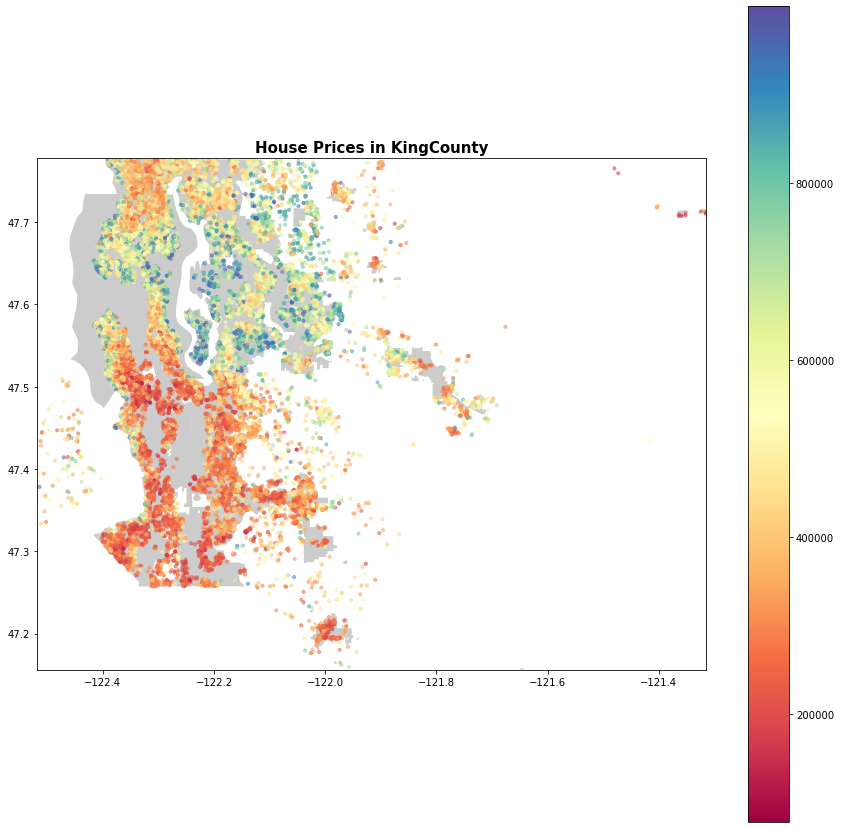

In [12]:
fig, ax = plt.subplots(figsize=(15,15))

street_map.plot(ax=ax, alpha=0.4,color='grey')

less_df.plot(column='price',ax=ax,alpha=0.5, legend=True, markersize=10, cmap='Spectral')

plt.title('House Prices in KingCounty', fontsize=15,fontweight='bold')

plt.xlim(raw_data.long.min(),raw_data.long.max())
plt.ylim(raw_data.lat.min(),raw_data.lat.max())

plt.show()

In [13]:
mill_geometry = [Point(xy) for xy in zip(million_house['long'], million_house['lat'])]

mill_df = gpd.GeoDataFrame(million_house, crs = 'EPSG:4326', geometry = mill_geometry)

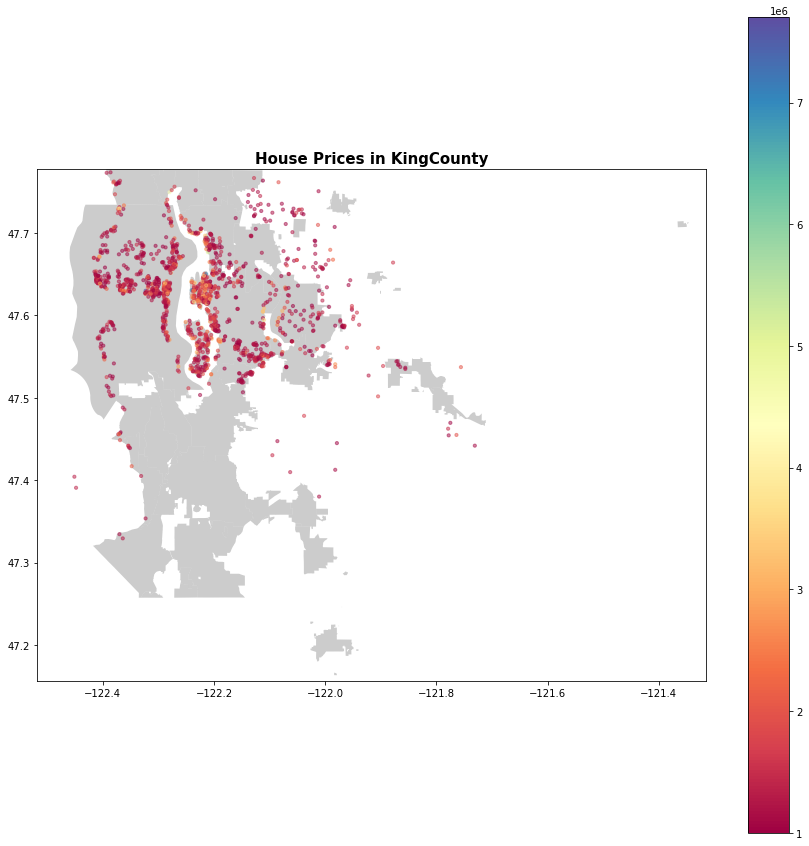

In [14]:
fig, ax = plt.subplots(figsize=(15,15))

street_map.plot(ax=ax, alpha=0.4,color='grey')

mill_df.plot(column='price',ax=ax,alpha=0.5, legend=True, markersize=10, cmap='Spectral')

plt.title('House Prices in KingCounty', fontsize=15,fontweight='bold')

plt.xlim(raw_data.long.min(),raw_data.long.max())
plt.ylim(raw_data.lat.min(),raw_data.lat.max())

plt.show()

In [15]:
# Drop columns
raw_data.drop(columns=['id', 'date', 'yr_renovated', 'sqft_above', 'sqft_basement',
                      'yr_built', 'yr_renovated'], inplace=True)

In [16]:
raw_data.head(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,lat,long,sqft_living15,sqft_lot15,month,basement,renovated,age
0,221900.0,3,1.00,1180,5650,1.0,0,0,2,7,98178,47.5112,-122.257,1340,5650,10,1,0,59
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,98125,47.7210,-122.319,1690,7639,12,1,1,63


In [ ]:
raw_data.bedrooms.value_counts()

In [ ]:
raw_data.loc[(raw_data.bedrooms == 33), :]

In [ ]:
raw_data.bathrooms.value_counts()

In [ ]:
raw_data.loc[(raw_data.bathrooms >6), :]

- Discrete: bedrooms, bathrooms, floors, condition, grade, age
- Continuous: price, sqft_living, sqft_lot, sqft_living15, sqft_lot15
- Categorical: waterfront, view, zipcode, month or season, basement, renovated

In [17]:
def corr_check(df, threshold):
    '''
    Enter dataframe and threshold for correlation
    Returns table of the highly correlated pairs
    '''
    corr_df = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))
    corr_df.set_index(['pairs'], inplace = True)
    corr_df.drop(columns=['level_1', 'level_0'], inplace = True)
    corr_df.columns = ['cc']
    corr_df = corr_df.drop_duplicates()
    corr_df = corr_df[(corr_df['cc'] > threshold) & (corr_df['cc'] < 1)]
    return corr_df

corr_check(raw_data, .5)

,cc
pairs,
"(grade, sqft_living)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(bathrooms, sqft_living)",0.755758
"(sqft_lot15, sqft_lot)",0.718204
"(sqft_living15, grade)",0.713867
"(price, sqft_living)",0.701917
"(price, grade)",0.667951
"(bathrooms, grade)",0.665838
"(sqft_living15, price)",0.585241


In [18]:
to_drop = ['price', 'waterfront', 'view', 'zipcode', 
           'month', 'basement', 'renovated', 'lat', 'long', 
           'sqft_living15', 'sqft_lot15', 'grade', 'bathrooms', 'sqft_lot']
y = raw_data[['price']]
X = raw_data.drop(to_drop, axis=1)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [21]:
import statsmodels.api as sm

model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model.rsquared

0.5532987178179887

In [22]:
X_train.columns

Index(['bedrooms', 'sqft_living', 'floors', 'condition', 'age'], dtype='object')

In [23]:
to_transform = ['sqft_living']
log_df = X_train.copy()

for col in to_transform:
    log_df[col] = np.log(log_df[col])

In [24]:
model = sm.OLS(y_train, sm.add_constant(log_df)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     2621.
Date:                Mon, 03 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:48:32   Log-Likelihood:            -2.4110e+05
No. Observations:               17277   AIC:                         4.822e+05
Df Residuals:                   17271   BIC:                         4.823e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.414e+06   4.75e+04    -92.991      0.000   -4.51e+06   -4.32e+06
bedrooms    -5.714e+04   3048.831    -18.743      0.000   -6.31e+04   -5.12e+04
sqft_living  6.398e+05   7021.457     91.114      0.000    6.26e+05    6.54e+05
floors       9.601e+04   4659.410     20.605      0.000    8.69e+04    1.05e+05
condition    1.701e+04   3537.960      4.808      0.000    1.01e+04    2.39e+04
age          3035.2128     88.548     34.278      0.000    2861.651    3208.775
==============================================================================
Omnibus:                    15686.892   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1403645.605
Skew:                           4.035   Prob(JB):                         0.00
Kurtosis:                      46.414   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)

X_scaled.head()

,bedrooms,sqft_living,floors,condition,age
0,0.691203,-0.701342,0.933592,0.905470,-0.046214
1,-0.414530,-0.712241,-0.915081,0.905470,-0.284646
2,0.691203,1.129672,0.933592,-0.631098,-1.340557
3,0.691203,-0.025611,-0.915081,-0.631098,-0.080276
4,-0.414530,0.453941,0.009256,2.442038,1.656869
